# **Classification-based Rating Mode Prediction using Embedding Features**


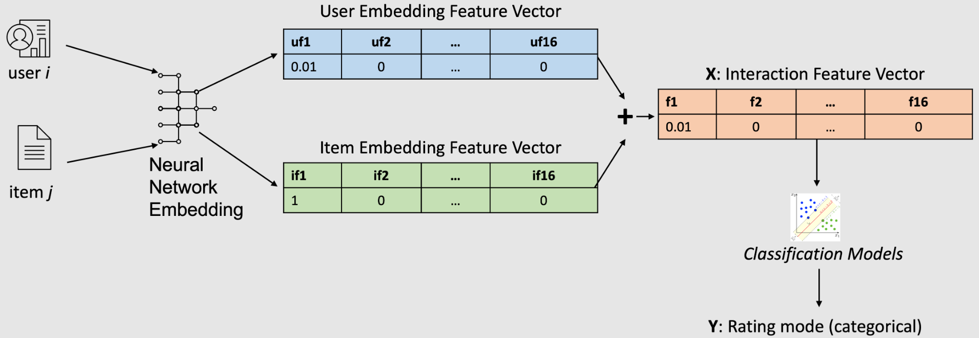


<font color=salmon size=4>The workflow is very similar to our previous lab. We first extract two embedding matrices out of the neural network, and aggregate them to be a single interaction feature vector as input data `X`.

<font color=salmon size=4>This time, with the interaction label `Y` as categorical rating mode, we can build classification models to approximate the mapping from `X` to `Y`, as shown in the above flowchart.


## Objectives


* <font color=salmon size=4>Build classification models to predict rating modes using the combined embedding vectors


----


## Prepare and setup lab environment


In [1]:
#!pip install scikit-learn==1.0.2

In [2]:
# also set a random state
rs = 123

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Load datasets


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

<font color=salmon size=4>The first dataset is the rating dataset contains user-item interaction matrix


In [5]:
rating_df = pd.read_csv(rating_url)

In [6]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


<font color=salmon size=4>As you can see from the above data, the user and item are just ids, let's substitute them with their embedding vectors


In [7]:
user_emb = pd.read_csv(user_emb_url)
item_emb = pd.read_csv(item_emb_url)

In [8]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [9]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [10]:
# Merge user embedding features
merged_df = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(merged_df, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [11]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3.0,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,3.0,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,3.0,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3.0,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


<font color=salmon size=4>Each user's embedding features and each item's embedding features are added to the dataset. Next, we perform element-wise add the user features (the column labels starting with `UFeature`) and item features (the column labels starting with `CFeature`).


In [12]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
interaction_dataset.columns = [f"Feature{i}" for i in range(16)]
interaction_dataset['rating'] = ratings
interaction_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


<font color=salmon size=4>Next, let's use `LabelEncoder()` to encode our `rating` label to be categorical:


In [13]:
X = interaction_dataset.iloc[:, :-1]
y_raw = interaction_dataset.iloc[:, -1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

<font color=salmon size=4>and split X and y into training and testing dataset:


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [15]:
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


## TASK: Perform classification tasks on the interaction dataset


<font color=salmon size=4>Now our input data `X` and output label `y` is ready, let's build classification models to map `X` to `y`


<font color=salmon size=4>You may use `sklearn` to train and evaluate various regression models.


<font color=salmon size=4>_TODO: Define classification models such as Logistic Regression, Tree models, SVM, Bagging, and Boosting models_


In [17]:
### WRITE YOUR CODE HERE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC

# Logistic Regression
logreg = LogisticRegression(random_state=rs)
logreg.fit(X_train, y_train)

# Decision Tree
dtree = DecisionTreeClassifier(max_depth=5, random_state=rs)
dtree.fit(X_train, y_train)

# Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=rs)
rfc.fit(X_train, y_train)

# Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=rs)
gbc.fit(X_train, y_train)

# Bagging Classifier
bag = BaggingClassifier(n_estimators=100, random_state=rs)
bag.fit(X_train, y_train)

# Support Vector Machine
svm = SVC(kernel='linear', random_state=rs)
svm.fit(X_train, y_train)


SVC(kernel='linear', random_state=123)

<font color=salmon size=4>_TODO: Evaluate your classification models_


In [22]:
### WRITE YOUR CODE HERE

### The main evaluation metrics could be accuracy, recall, precision, F score, and AUC.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("----------------------")

# Evaluate the models

models = [logreg, dtree, rfc, gbc, bag, svm]

for model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall, precision, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f"{type(model).__name__:<35} {'accuracy:':<10} {accuracy:.4f}")
    print(f"{type(model).__name__:<35} {'recall:':<10} {recall:.4f}")
    print(f"{type(model).__name__:<35} {'precision:':<10} {precision:.4f}")
    print(f"{type(model).__name__:<35} {'f1_score:':<10} {f1_score:.4f}")
    print("----------------------")


----------------------
LogisticRegression                  accuracy:  0.9545
LogisticRegression                  recall:    0.9545
LogisticRegression                  precision: 1.0000
LogisticRegression                  f1_score:  0.9767
----------------------
DecisionTreeClassifier              accuracy:  0.9545
DecisionTreeClassifier              recall:    0.9545
DecisionTreeClassifier              precision: 0.9999
DecisionTreeClassifier              f1_score:  0.9767
----------------------
RandomForestClassifier              accuracy:  0.9545
RandomForestClassifier              recall:    0.9545
RandomForestClassifier              precision: 1.0000
RandomForestClassifier              f1_score:  0.9767
----------------------
GradientBoostingClassifier          accuracy:  0.9787
GradientBoostingClassifier          recall:    0.9810
GradientBoostingClassifier          precision: 0.9970
GradientBoostingClassifier          f1_score:  0.9889
----------------------
BaggingClassifier    

<h3 style="color:#A569BD; font-size:2em;">Summary:</h3>

<div style="color:#85C1E9; font-size:1.5em;">
Based on the evaluation metrics (accuracy, recall, precision, and f1-score), both <span style="color:#A569BD;"><em>Gradient Boosting Classifier</em></span> and <span style="color:#A569BD;"><em>Bagging Classifier</em></span> have the highest accuracy and f1-score. However, the <span style="color:#F8C471"><strong>Bagging Classifier</strong></span> has a slightly higher precision, which means it has fewer false positives. Therefore, we can choose Bagging Classifier as the best performing model for this dataset.
<br>
It is worth noting that both Gradient Boosting and Bagging models outperformed the other models in terms of accuracy and f1-score.
    
</div>